In [7]:
import numpy as np
import pandas as pd

import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid import ImageGrid

from tqdm.notebook import tqdm
import time
import random

plt.style.use("dark_background")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  


In [8]:
BASE_PATH= "/kaggle/input/lgg-mri-segmentation/kaggle_3m"

In [9]:
BASE_LEN = 89
END_LEN = 4
END_MASK_LEN = 9

IMG_SIZE = 512

# Get & Prepare Data

In [10]:
data = []

for dir_ in os.listdir(BASE_PATH):
    dir_path = os.path.join(BASE_PATH, dir_)
    if os.path.isdir(dir_path):
        for filename in os.listdir(dir_path):
            img_path = os.path.join(dir_path, filename)
            data.append([dir_, img_path])
    else:
        print(f"[INFO] This is not a dir --> {dir_path}")
        
df = pd.DataFrame(data, columns=["dir_name", "image_path"])


[INFO] This is not a dir --> /kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md
[INFO] This is not a dir --> /kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv


In [11]:
df_imgs = df[~df["image_path"].str.contains("mask")]
df_masks = df[df["image_path"].str.contains("mask")]

In [12]:
imgs = sorted(df_imgs["image_path"].values, key= lambda x: int(x[BASE_LEN: -END_LEN]))
masks = sorted(df_masks["image_path"].values, key=lambda x: int(x[BASE_LEN: -END_MASK_LEN]))

In [13]:
# sanity check
idx = random.randint(0, len(imgs)-1)
print(f"This image *{imgs[idx]}*\n Belongs to the mask *{masks[idx]}*")

This image */kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_10.tif*
 Belongs to the mask */kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_10_mask.tif*


In [14]:
# final dataframe
dff = pd.DataFrame({"patient": df_imgs.dir_name.values,
                   "image_path": imgs,
                   "mask_path": masks})

dff.head()

,patient,image_path,mask_path
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [15]:
def pos_neg_diagnosis(mask_path):
    val = np.max(cv2.imread(mask_path))
    if val > 0: return 1
    else: return 0

In [16]:
dff["diagnosis"] = dff["mask_path"].apply(lambda x: pos_neg_diagnosis(x))

dff.head()

,patient,image_path,mask_path,diagnosis
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0


In [17]:
dff.shape

(3929, 4)

In [18]:
print("Amount of patients: ", len(set(dff.patient)))
print("Amount of records: ", len(dff))

Amount of patients:  110
Amount of records:  3929


# Data Augmentation

In [19]:
!pip install albumentations==0.4.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 1.2 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=a1baca20633819ab59429e1234513e9bab9f8266dc4ae22b140dd0dbd9f74c92
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.3.0
    Uninstalling albumentations-1.3.0:
      Successfully uninstalled albumentations-1.3.0


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2, ToTensor

from sklearn.model_selection import train_test_split

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [22]:
class BrainMRIDataset:
    def __init__(self, df, transforms):
        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 1])
        mask = cv2.imread(self.df.iloc[idx, 2], 0)
        
        augmented = self.transforms(image=image,
                                   mask=mask)
        
        image = augmented["image"]
        mask = augmented["mask"]
        
        return image, mask

In [23]:
PATCH_SIZE = 128

transforms = A.Compose([
    A.Resize(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),

    A.Normalize(p=1.0),
    ToTensor(),
    
])

# Split Data and DataLoaders

In [24]:
train_df, val_df = train_test_split(dff, stratify=dff.diagnosis, test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df, test_df = train_test_split(train_df, stratify=train_df.diagnosis, test_size=0.12)
train_df = train_df.reset_index(drop=True)

print(f"Train: {train_df.shape} \nVal: {val_df.shape} \nTest: {test_df.shape}")

Train: (3111, 4) 
Val: (393, 4) 
Test: (425, 4)


In [25]:
train_dataset = BrainMRIDataset(train_df, transforms=transforms)
train_dataloader = DataLoader(train_dataset, batch_size=26, num_workers=2, shuffle=True)

val_dataset = BrainMRIDataset(val_df, transforms=transforms)
val_dataloader = DataLoader(val_dataset, batch_size=26, num_workers=2, shuffle=True)

test_dataset = BrainMRIDataset(test_df, transforms=transforms)
test_dataloader = DataLoader(test_dataset, batch_size=26, num_workers=2, shuffle=True)

In [26]:
def show_aug(inputs, nrows=5, ncols=5, norm=False):
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0., hspace=0.)
    i_ = 0
    
    if len(inputs) > 25:
        inputs = inputs[:25]
        
    for idx in range(len(inputs)):
    
        # normalization
        if norm:           
            img = inputs[idx].numpy().transpose(1,2,0)
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225] 
            img = (img*std+mean).astype(np.float32)
            
        else:
            img = inputs[idx].numpy().astype(np.float32)
            img = img[0,:,:]
        
        plt.subplot(nrows, ncols, i_+1)
        plt.imshow(img); 
        plt.axis('off')
 
        i_ += 1
        
    return plt.show()

torch.Size([26, 3, 128, 128]) torch.Size([26, 1, 128, 128])


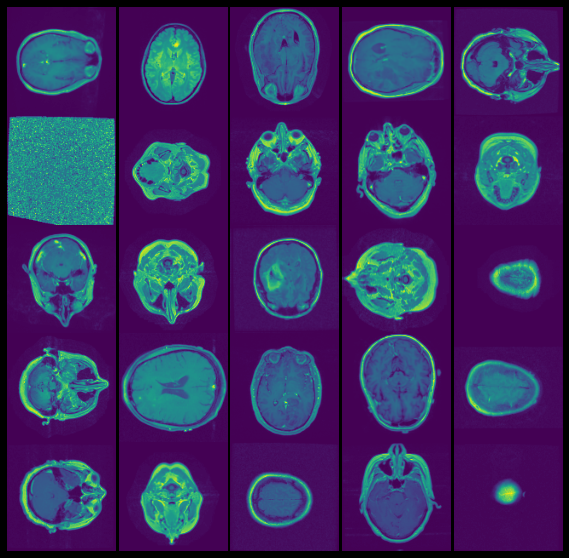

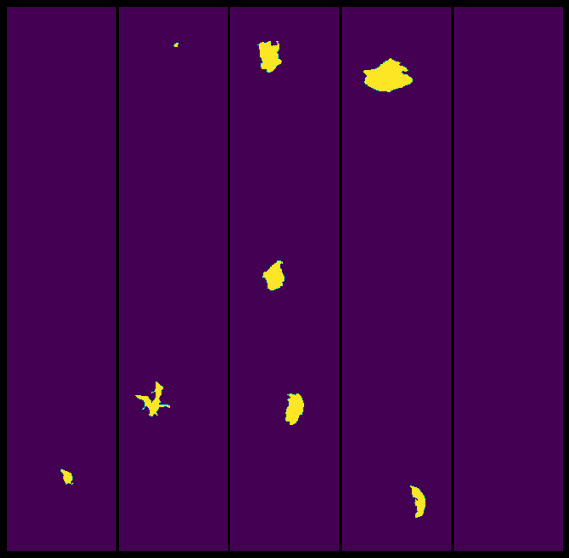

In [27]:
images, masks = next(iter(train_dataloader))
print(images.shape, masks.shape)

show_aug(images)
show_aug(masks, norm=False)

# Attention U-Net

## Model Blocks

In [28]:
class ConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out):
        super().__init__()
        self.conv = nn.Sequential(
                                  nn.Conv2d(ch_in, ch_out,
                                            kernel_size=3, stride=1,
                                            padding=1, bias=True),
                                  nn.BatchNorm2d(ch_out),
                                  nn.ReLU(inplace=True),
                                  nn.Conv2d(ch_out, ch_out,
                                            kernel_size=3, stride=1,
                                            padding=1, bias=True),
                                  nn.BatchNorm2d(ch_out),
                                  nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        x = self.conv(x)
        return x

In [29]:
class UpConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out):
        super().__init__()
        self.up = nn.Sequential(
                                nn.Upsample(scale_factor=2),
                                nn.Conv2d(ch_in, ch_out,
                                         kernel_size=3,stride=1,
                                         padding=1, bias=True),
                                nn.BatchNorm2d(ch_out),
                                nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        x = x = self.up(x)
        return x

In [30]:
class AttentionBlock(nn.Module):
    def __init__(self, f_g, f_l, f_int):
        super().__init__()
        
        self.w_g = nn.Sequential(
                                nn.Conv2d(f_g, f_int,
                                         kernel_size=1, stride=1,
                                         padding=0, bias=True),
                                nn.BatchNorm2d(f_int)
        )
        
        self.w_x = nn.Sequential(
                                nn.Conv2d(f_l, f_int,
                                         kernel_size=1, stride=1,
                                         padding=0, bias=True),
                                nn.BatchNorm2d(f_int)
        )
        
        self.psi = nn.Sequential(
                                nn.Conv2d(f_int, 1,
                                         kernel_size=1, stride=1,
                                         padding=0,  bias=True),
                                nn.BatchNorm2d(1),
                                nn.Sigmoid(),
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, g, x):
        g1 = self.w_g(g)
        x1 = self.w_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)
        
        return psi*x

## U-Net Model

In [31]:
class AttentionUNet(nn.Module):
    def __init__(self, n_classes=1, in_channel=3, out_channel=1):
        super().__init__() 
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv1 = ConvBlock(ch_in=in_channel, ch_out=64)
        self.conv2 = ConvBlock(ch_in=64, ch_out=128)
        self.conv3 = ConvBlock(ch_in=128, ch_out=256)
        self.conv4 = ConvBlock(ch_in=256, ch_out=512)
        self.conv5 = ConvBlock(ch_in=512, ch_out=1024)
        
        self.up5 = UpConvBlock(ch_in=1024, ch_out=512)
        self.att5 = AttentionBlock(f_g=512, f_l=512, f_int=256)
        self.upconv5 = ConvBlock(ch_in=1024, ch_out=512)
        
        self.up4 = UpConvBlock(ch_in=512, ch_out=256)
        self.att4 = AttentionBlock(f_g=256, f_l=256, f_int=128)
        self.upconv4 = ConvBlock(ch_in=512, ch_out=256)
        
        self.up3 = UpConvBlock(ch_in=256, ch_out=128)
        self.att3 = AttentionBlock(f_g=128, f_l=128, f_int=64)
        self.upconv3 = ConvBlock(ch_in=256, ch_out=128)
        
        self.up2 = UpConvBlock(ch_in=128, ch_out=64)
        self.att2 = AttentionBlock(f_g=64, f_l=64, f_int=32)
        self.upconv2 = ConvBlock(ch_in=128, ch_out=64)
        
        self.conv_1x1 = nn.Conv2d(64, out_channel,
                                  kernel_size=1, stride=1, padding=0)
        
    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        
        x2 = self.maxpool(x1)
        x2 = self.conv2(x2)
        
        x3 = self.maxpool(x2)
        x3 = self.conv3(x3)
        
        x4 = self.maxpool(x3)
        x4 = self.conv4(x4)
        
        x5 = self.maxpool(x4)
        x5 = self.conv5(x5)
        
        # decoder + concat
        d5 = self.up5(x5)
        x4 = self.att5(g=d5, x=x4)
        d5 = torch.concat((x4, d5), dim=1)
        d5 = self.upconv5(d5)
        
        d4 = self.up4(d5)
        x3 = self.att4(g=d4, x=x3)
        d4 = torch.concat((x3, d4), dim=1)
        d4 = self.upconv4(d4)
        
        d3 = self.up3(d4)
        x2 = self.att3(g=d3, x=x2)
        d3 = torch.concat((x2, d3), dim=1)
        d3 = self.upconv3(d3)
        
        d2 = self.up2(d3)
        x1 = self.att2(g=d2, x=x1)
        d2 = torch.concat((x1, d2), dim=1)
        d2 = self.upconv2(d2)
        
        d1 = self.conv_1x1(d2)
        
        return d1

In [32]:
attention_unet = AttentionUNet(n_classes=1).to(device)

In [33]:
# check sanity
output = torch.randn(1,3,256,256).to(device)
output.shape

torch.Size([1, 3, 256, 256])

## ResNet and DenseNet

In [79]:
import torchvision.models as models

class ResNetUNet(nn.Module):
    def __init__(self, n_classes=1, pretrained=True):
        super().__init__()
        self.base_model = models.resnet18(pretrained=pretrained)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3])
        self.layer0_1x1 = ConvBlock(64, 64)
        self.layer1 = nn.Sequential(*self.base_layers[3:5])
        self.layer1_1x1 = ConvBlock(64, 64)
        self.layer2 = self.base_layers[5]
        self.layer2_1x1 = ConvBlock(128, 128)
        self.layer3 = self.base_layers[6]
        self.layer3_1x1 = ConvBlock(256, 256)
        self.layer4 = self.base_layers[7]
        self.layer4_1x1 = ConvBlock(512, 512)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = ConvBlock(256 + 512, 512)
        self.conv_up2 = ConvBlock(128 + 512, 256)
        self.conv_up1 = ConvBlock(64 + 256, 256)
        self.conv_up0 = ConvBlock(64 + 256, 128)

        self.conv_original_size0 = ConvBlock(3, 64)
        self.conv_original_size1 = ConvBlock(64, 64)
        self.conv_original_size2 = ConvBlock(64 + 128, 64)

        self.conv_last = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x_original = self.conv_original_size0(x)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(x)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

In [81]:
class DenseNetUNet(nn.Module):
    def __init__(self, n_classes=1, pretrained=True):
        super().__init__()
        self.base_model = models.densenet121(pretrained=pretrained)
        self.base_layers = list(self.base_model.features.children())

        self.layer0 = nn.Sequential(*self.base_layers[:4])
        self.layer1 = nn.Sequential(*self.base_layers[4:6])
        self.layer2 = nn.Sequential(*self.base_layers[6:8])
        self.layer3 = nn.Sequential(*self.base_layers[8:10])
        self.layer4 = nn.Sequential(*self.base_layers[10:12])

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up4 = ConvBlock(1024, 512)
        self.conv_up3 = ConvBlock(512, 256)
        self.conv_up2 = ConvBlock(256, 128)
        self.conv_up1 = ConvBlock(128, 64)

        self.conv_original_size0 = ConvBlock(3, 64)
        self.conv_original_size1 = ConvBlock(64, 64)
        self.conv_original_size2 = ConvBlock(128, 64)  # Updated to take 128 channels as input

        self.conv_last = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x_original = self.conv_original_size0(x)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(x)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        x = self.upsample(layer4)
        x = self.conv_up4(x)

        x = self.upsample(x)
        x = self.conv_up3(x)

        x = self.upsample(x)
        x = self.conv_up2(x)

        x = self.upsample(x)
        x = self.conv_up1(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)  # Concatenate upsampled features with original input
        x = self.conv_original_size2(x)  # Process the concatenated features

        out = self.conv_last(x)

        return out

In [82]:
resnet_unet = ResNetUNet(n_classes=1).to(device)
densenet_unet = DenseNetUNet(n_classes=1).to(device)

# Segmentation Metric

In [64]:
def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target*inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0 
    return intersection/union

# Segmentation Loss

In [65]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [66]:
# sanity check
DiceLoss()(torch.tensor([0.7, 1., 1.]), 
              torch.tensor([1.,1.,1.]))

tensor(0.1419)

# Training

In [67]:
def train_model(model_name, model, train_loader, val_loader, train_loss, optimizer, lr_scheduler, num_epochs):
    print(f"[INFO] Model is initializing... {model_name}")
    
    loss_history = []
    train_history = []
    val_history = []
    
    for epoch in range(num_epochs):
        model.train()
        
        losses = []
        train_iou = []
        
        for i_step, (data, target) in enumerate(tqdm(train_loader)):
            data = data.to(device)
            target = target.to(device)
            
            outputs = model(data)
            
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            
            train_dice = dice_coef_metric(out_cut, target.data.cpu().numpy())
            
            loss = train_loss(outputs, target)
            
            losses.append(loss.item())
            train_iou.append(train_dice)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        val_mean_iou = compute_iou(model, val_loader)
        
        loss_history.append(np.array(losses).mean())
        train_history.append(np.array(train_iou).mean())
        val_history.append(val_mean_iou)
        
        print("Epoch [%d]" % (epoch))
        print("Mean loss on train:", np.array(losses).mean(), 
              "\nMean DICE on train:", np.array(train_iou).mean(), 
              "\nMean DICE on validation:", val_mean_iou)
        
    return loss_history, train_history, val_history

In [68]:
def compute_iou(model, loader, threshold=0.3):
    valloss = 0
    
    with torch.no_grad():

        for i_step, (data, target) in enumerate(loader):
            
            data = data.to(device)
            target = target.to(device)
            
            outputs = model(data)

            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0
            picloss = dice_coef_metric(out_cut, target.data.cpu().numpy())
            valloss += picloss

    return valloss / i_step

In [83]:
opt = torch.optim.Adamax(attention_unet.parameters(), lr=1e-3)
opt_resnet = torch.optim.Adamax(resnet_unet.parameters(), lr=1e-3)
opt_densenet = torch.optim.Adamax(densenet_unet.parameters(), lr=1e-3)

In [84]:
%%time
num_ep = 50
# after 30 does not improve much

aun_lh, aun_th, aun_vh = train_model("Attention UNet", attention_unet, train_dataloader, val_dataloader, DiceLoss(), opt, False, num_ep)
rn_lh, rn_th, rn_vh = train_model("ResNet UNet", resnet_unet, train_dataloader, val_dataloader, DiceLoss(), opt_resnet, False, num_ep)
dn_lh, dn_th, dn_vh = train_model("DenseNet UNet", densenet_unet, train_dataloader, val_dataloader, DiceLoss(), opt_densenet, False, num_ep)

[INFO] Model is initializing... DenseNet UNet


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [0]
Mean loss on train: 0.9138218834996223 
Mean DICE on train: 0.2846927918862869 
Mean DICE on validation: 0.47645429177389825


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [1]
Mean loss on train: 0.7467845539251964 
Mean DICE on train: 0.5369160608019091 
Mean DICE on validation: 0.6633757399239651


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [2]
Mean loss on train: 0.45454449355602267 
Mean DICE on train: 0.6717205046387896 
Mean DICE on validation: 0.7642775868062763


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [3]
Mean loss on train: 0.32267497132221856 
Mean DICE on train: 0.7203713590898853 
Mean DICE on validation: 0.7639463914471462


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [4]
Mean loss on train: 0.2606924161314964 
Mean DICE on train: 0.7609999254230954 
Mean DICE on validation: 0.7601144625352616


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [5]
Mean loss on train: 0.23757635603348415 
Mean DICE on train: 0.7764175224293884 
Mean DICE on validation: 0.8439540236395905


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [6]
Mean loss on train: 0.23868175595998764 
Mean DICE on train: 0.7723711137344923 
Mean DICE on validation: 0.8429098931778807


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [7]
Mean loss on train: 0.21454838663339615 
Mean DICE on train: 0.7944938265951978 
Mean DICE on validation: 0.7970417445748641


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [8]
Mean loss on train: 0.20349108825127285 
Mean DICE on train: 0.8032851170518793 
Mean DICE on validation: 0.8338124933221199


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [9]
Mean loss on train: 0.19505503525336584 
Mean DICE on train: 0.8101465462790114 
Mean DICE on validation: 0.8602813808688361


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [10]
Mean loss on train: 0.1940855195124944 
Mean DICE on train: 0.8104844287522636 
Mean DICE on validation: 0.8744841153815607


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [11]
Mean loss on train: 0.1920515591899554 
Mean DICE on train: 0.8115011430444429 
Mean DICE on validation: 0.8736312764589739


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [14]
Mean loss on train: 0.17670546372731527 
Mean DICE on train: 0.8258067674277855 
Mean DICE on validation: 0.826468226528437


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [15]
Mean loss on train: 0.17462492386500042 
Mean DICE on train: 0.8276289502073387 
Mean DICE on validation: 0.829860497710635


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [16]
Mean loss on train: 0.16878116180499395 
Mean DICE on train: 0.8334418979085915 
Mean DICE on validation: 0.8739974677651575


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [17]
Mean loss on train: 0.16712749898433685 
Mean DICE on train: 0.8353158655528664 
Mean DICE on validation: 0.8786489499318044


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [18]
Mean loss on train: 0.16611687143643697 
Mean DICE on train: 0.8361161670184882 
Mean DICE on validation: 0.8305284178685227


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [19]
Mean loss on train: 0.16142241805791854 
Mean DICE on train: 0.8402745971835507 
Mean DICE on validation: 0.8414756347156956


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [20]
Mean loss on train: 0.15040277441342673 
Mean DICE on train: 0.8513766822947477 
Mean DICE on validation: 0.886222744560856


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [21]
Mean loss on train: 0.14765651822090148 
Mean DICE on train: 0.8540609166409754 
Mean DICE on validation: 0.8805164725674436


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [22]
Mean loss on train: 0.14307338396708172 
Mean DICE on train: 0.8584506453710624 
Mean DICE on validation: 0.8775445678537028


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [23]
Mean loss on train: 0.14923466940720875 
Mean DICE on train: 0.8527777688526302 
Mean DICE on validation: 0.8690549814153883


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [24]
Mean loss on train: 0.14873772313197453 
Mean DICE on train: 0.8528705653258088 
Mean DICE on validation: 0.9241887285977142


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [25]
Mean loss on train: 0.13605676889419555 
Mean DICE on train: 0.8653913603786145 
Mean DICE on validation: 0.9395288135579448


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [26]
Mean loss on train: 0.13566090067227682 
Mean DICE on train: 0.8656243701585851 
Mean DICE on validation: 0.8703246244877224


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [27]
Mean loss on train: 0.1412999783953031 
Mean DICE on train: 0.86001296767409 
Mean DICE on validation: 0.9099313532491787


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [28]
Mean loss on train: 0.13243959844112396 
Mean DICE on train: 0.8688692281337793 
Mean DICE on validation: 0.9057439868133427


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [29]
Mean loss on train: 0.12930844326814014 
Mean DICE on train: 0.8718367386973335 
Mean DICE on validation: 0.8741733653259404


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [30]
Mean loss on train: 0.12609875003496807 
Mean DICE on train: 0.8750023334101875 
Mean DICE on validation: 0.9277985295700113


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [31]
Mean loss on train: 0.12358169505993526 
Mean DICE on train: 0.8773248200589199 
Mean DICE on validation: 0.9342327181701118


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [32]
Mean loss on train: 0.1270015388727188 
Mean DICE on train: 0.874109977721984 
Mean DICE on validation: 0.9270201682196677


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [33]
Mean loss on train: 0.1196354866027832 
Mean DICE on train: 0.8813041933729913 
Mean DICE on validation: 0.9031330955557878


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [34]
Mean loss on train: 0.12031054695447287 
Mean DICE on train: 0.8805647371535976 
Mean DICE on validation: 0.9465270841819657


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [35]
Mean loss on train: 0.11972433725992838 
Mean DICE on train: 0.8811923180805223 
Mean DICE on validation: 0.9190304478420358


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [36]
Mean loss on train: 0.12342760860919952 
Mean DICE on train: 0.8775628870366511 
Mean DICE on validation: 0.9245405178282795


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [37]
Mean loss on train: 0.11816028008858363 
Mean DICE on train: 0.8826824252669767 
Mean DICE on validation: 0.872322025018386


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [38]
Mean loss on train: 0.11581912835439047 
Mean DICE on train: 0.8849090472991658 
Mean DICE on validation: 0.9150977135764926


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [39]
Mean loss on train: 0.12394996881484985 
Mean DICE on train: 0.8770850049748776 
Mean DICE on validation: 0.9367602674509272


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [40]
Mean loss on train: 0.1176852434873581 
Mean DICE on train: 0.8832471354514273 
Mean DICE on validation: 0.8815371524244464


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [41]
Mean loss on train: 0.11543376843134562 
Mean DICE on train: 0.8853264061318131 
Mean DICE on validation: 0.9362453408424468


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [42]
Mean loss on train: 0.11055033852656683 
Mean DICE on train: 0.8901821282477645 
Mean DICE on validation: 0.94181849452739


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [43]
Mean loss on train: 0.11651403854290644 
Mean DICE on train: 0.8844210328393469 
Mean DICE on validation: 0.9211487359469417


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [44]
Mean loss on train: 0.10681342283884684 
Mean DICE on train: 0.8939744219550457 
Mean DICE on validation: 0.9421685123011179


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [45]
Mean loss on train: 0.11170465598503748 
Mean DICE on train: 0.8951033372106106 
Mean DICE on validation: 0.9468679055998294


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [46]
Mean loss on train: 0.10084189673264822 
Mean DICE on train: 0.8999262286158405 
Mean DICE on validation: 0.8799443708065552


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [47]
Mean loss on train: 0.10191915531953176 
Mean DICE on train: 0.8988336333620318 
Mean DICE on validation: 0.9447719096919054


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [48]
Mean loss on train: 0.10149693340063096 
Mean DICE on train: 0.8992954062701538 
Mean DICE on validation: 0.9518126364450663


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [49]
Mean loss on train: 0.10475578506787618 
Mean DICE on train: 0.89594759036278 
Mean DICE on validation: 0.9409639209041271
CPU times: user 37min 14s, sys: 10min 11s, total: 47min 26s
Wall time: 47min 46s


In [85]:
def plot_model_history(model_name,
                        train_history, val_history, 
                        num_epochs):
    
    x = np.arange(num_epochs)

    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_history, label='train dice', lw=3, c="springgreen")
    plt.plot(x, val_history, label='validation dice', lw=3, c="deeppink")

    plt.title(f"{model_name}", fontsize=15)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE", fontsize=15)

    fn = str(int(time.time())) + ".png"
    plt.show()

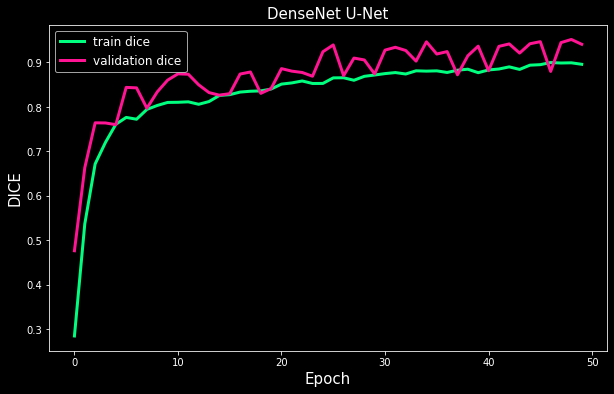

In [86]:
plot_model_history("DenseNet U-Net", dn_th, dn_vh, num_ep)

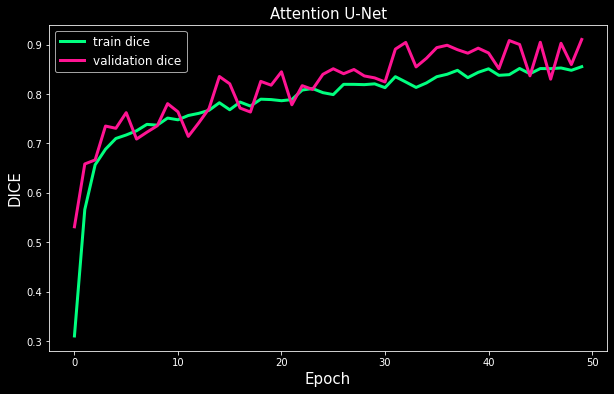

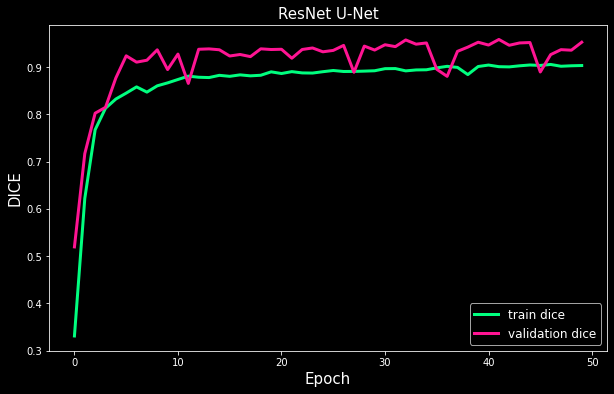

NameError: name 'dn_th' is not defined

In [48]:
plot_model_history("Attention U-Net", aun_th, aun_vh, num_ep)
plot_model_history("ResNet U-Net", rn_th, rn_vh, num_ep)
plot_model_history("DenseNet U-Net", dn_th, dn_vh, num_ep)

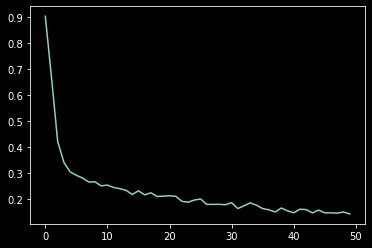

In [49]:
plt.plot(range(num_ep), aun_lh)

In [89]:
test_iou = compute_iou(attention_unet, test_dataloader)
test_iou_aun = compute_iou(densenet_unet, test_dataloader)
test_iou_rn = compute_iou(resnet_unet, test_dataloader)
print(f"""Performance comparison:
Attention U-Net: Mean IoU - {np.around(test_iou, 2)*100}%
ResNet U-Net: Mean IoU - {np.around(test_iou_rn, 2)*100}%
DenseNet U-Net: Mean IoU - {np.around(test_iou_aun, 2)*100}%""")


Performance comparison:
Attention U-Net: Mean IoU - 86.0%
ResNet U-Net: Mean IoU - 1.0%
DenseNet U-Net: Mean IoU - 95.0%
